In [2]:
!pip install mediapipe opencv-python

In [3]:
import os 
#current dir
cwd = os.getcwd()
print(cwd)

C:\Users\Aaron\Desktop\MasterProjects


In [4]:
import cv2
import mediapipe as mp
import numpy as np
import math
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

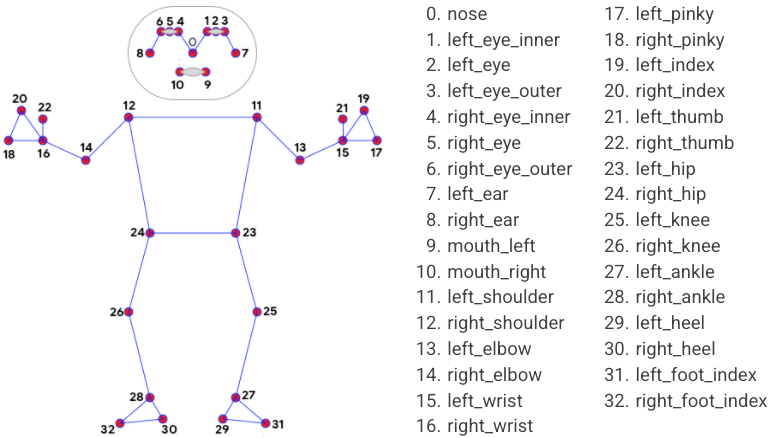

In [5]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle

def calculate_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    distance = abs(np.sqrt((a[0]-b[0])*(a[0]-b[0]) + (a[1]-b[1])*(a[1]-b[1])))
    return distance

def find_angles(landmarks, threshold):
    angle_array = []
    L_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    L_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
    L_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
    L_hip =   [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,  landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    L_knee =  [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    L_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
    
    R_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    R_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
    R_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
    R_hip =   [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,  landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    R_knee =  [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    R_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
    
    
    #LS will be left shoulder, and LE will be left elbow...
    if threshold == 0:
        #In this case, we only care about the upper body
        #angle array will have the order of:
        # 0, Left Shoulder(LS), Elbow(LE), Wrist(LW)
        # 1, LE, LS, LH
        # 2  RS, RE, RW
        # 3  RE, RS, RH
        angle_array.append(calculate_angle(L_shoulder, L_elbow, L_wrist))
        angle_array.append(calculate_angle(L_elbow, L_shoulder, L_hip))
        angle_array.append(calculate_angle(R_shoulder, R_elbow, R_wrist))
        angle_array.append(calculate_angle(R_elbow, R_shoulder, R_hip))
    if threshold == 1:
        # In this case, we care about the whole body
        # angle array will have the order of:
        # 0, Left Shoulder(LS), Elbow(LE), Wrist(LW)
        # 1, LE, LS, LH
        # 2  RS, RE, RW
        # 3  RE, RS, RH
        # 4  LS, LH, LK
        # 5  LH, LK, LA
        # 6  RS, RH, RK
        # 7  RH, RK, RA
        angle_array.append(calculate_angle(L_shoulder, L_elbow, L_wrist))
        angle_array.append(calculate_angle(L_elbow, L_shoulder, L_hip))
        angle_array.append(calculate_angle(R_shoulder, R_elbow, R_wrist))
        angle_array.append(calculate_angle(R_elbow, R_shoulder, R_hip))
        
        angle_array.append(calculate_angle(L_shoulder, L_hip, L_knee))
        angle_array.append(calculate_angle(L_hip, L_knee, L_ankle))
        angle_array.append(calculate_angle(R_shoulder, R_hip, R_knee))
        angle_array.append(calculate_angle(R_hip, R_knee, R_ankle))
    return angle_array

def find_distance(landmarks):
    L_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
    R_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
    distance = calculate_distance(L_wrist, R_wrist)
    return distance

def similarity_scoring(angle_array_sample, angle_array_in, hand_distance, panelty):
    deduction = 0.0
    #decuct from 100
    #
    for i in range(len(angle_array_sample)):
        deduction +=abs(angle_array_sample[i] - angle_array_in[i])*panelty
        #print(deduction)
    deduction += distance*10
    deduction *= panelty
    score = 100 - deduction
    if score < 0:
        score = 0
    return score


In [12]:
threshold = 1

In [15]:
sus_img = cv2.imread("test_img3.png")

with mp_pose.Pose(static_image_mode = True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    image = cv2.cvtColor(sus_img, cv2.COLOR_BGR2RGB)
    image = cv2.flip(image,1)
    image.flags.writeable = False

    # Make detection
    results1= pose.process(image)

    # Recolor back to BGR
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Extract landmarks
    try:
        landmarks = results1.pose_landmarks.landmark

        # Calculate angle
        sample = find_angles(landmarks, threshold)
        distance_sample = find_distance(landmarks)
        cv2.putText(image, str(sample[0]), 
                           (550,150), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                            )
        cv2.putText(image, str(sample[1]), 
                           (550,200), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                            )
        cv2.putText(image, str(sample[2]), 
                           (50,150), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                            )
        cv2.putText(image, str(sample[3]), 
                           (50,200), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                            )
        cv2.putText(image, str(distance_sample), 
                           (50,400), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                            )
        
    except:
        pass


    # Render detections
    mp_drawing.draw_landmarks(image, results1.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                           mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                           mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                            )  
    cv2.imshow("Img_in", image)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()

In [14]:
cap_camera = cv2.VideoCapture("test4_1.mp4")
accuracy = 90
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap_camera.isOpened():
        ret2, frame2 = cap_camera.read()
        if ret2:
            image2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
            image2 = cv2.flip(image2,1)
            image2.flags.writeable = False

            # Make detection
            results2= pose.process(image2)

            # Recolor back to BGR
            image2.flags.writeable = True
            image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)

            # Extract landmarks
            try:
                landmarks = results2.pose_landmarks.landmark
                angle = find_angles(landmarks, threshold)
                #print(sample)
                #print(angle)
                distance_cam = find_distance(landmarks)
                distance = abs(distance_cam - distance_sample)
                #print(distance)
                cur_score = similarity_scoring(sample, angle, distance, 0.5)
                if cur_score>=accuracy:
                    cv2.putText(image2, "Detected", 
                                   (50,120), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA
                                    )
                cv2.putText(image2, str(cur_score), 
                                   (50,90), 
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                    )
            except:
                pass


            # Render detections
            mp_drawing.draw_landmarks(image2, results2.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(30,117,66), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(30,66,230), thickness=2, circle_radius=2) 
                                     )  
            cv2.imshow("camera", image2)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break



cap_camera.release()
cv2.destroyAllWindows()